In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Patch
from scipy.spatial.distance import pdist, squareform
from scipy import stats
import re
from datetime import datetime
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage

# Exploratory Data Analysis

## 1) Import the dataset and identify any missing values.

In [2]:
restaurants = pd.read_excel('Datasets/Evanston Restaurant Reviews.xlsx', sheet_name='Restaurants')
reviews = pd.read_excel('Datasets/Evanston Restaurant Reviews.xlsx', sheet_name='Reviews')

restaurants['Restaurant Name'] = restaurants['Restaurant Name'].str.strip()
reviews['Restaurant Name'] = reviews['Restaurant Name'].str.strip()

In [3]:
def correct_and_convert_dates(entry):
    # Check if the entry is a string, which might indicate a typo that needs correction
    if isinstance(entry, str):
        # Correct common date typos, such as '5-0-2022'
        pattern = r'(\d{1,2})-0-(\d{4})'
        replacement = r'\1-01-\2'  # Assumes January as the default month
        corrected_date = re.sub(pattern, replacement, entry)
        try:
            # Try converting the corrected string to datetime
            return pd.to_datetime(corrected_date, errors='coerce')
        except ValueError:
            # In case of other unrecognized formats, return NaT
            return pd.NaT
    else:
        # If it's already a datetime type or similar, return as is
        return entry

In [4]:
reviews['Date of Review'] = reviews['Date of Review'].apply(correct_and_convert_dates)

In [5]:
reviews_sorted = reviews.sort_values(by=['Reviewer Name', 'Date of Review'], ascending=[True, False])

# Drop duplicates, keeping only the first entry for each user-restaurant pair (which is the latest due to sorting)
reviews = reviews_sorted.drop_duplicates(subset=['Reviewer Name', 'Restaurant Name'])

In [6]:
columns_with_missing_data = restaurants.columns[restaurants.isnull().any()].tolist()
print("Columns with missing data:", columns_with_missing_data)

Columns with missing data: []


In [7]:
columns_with_missing_data = reviews.columns[reviews.isnull().any()].tolist()
print("Columns with missing data:", columns_with_missing_data)

Columns with missing data: ['Review Text', 'Birth Year', 'Marital Status', 'Has Children?', 'Vegetarian?', 'Weight (lb)', 'Height (in)', 'Average Amount Spent', 'Preferred Mode of Transport']


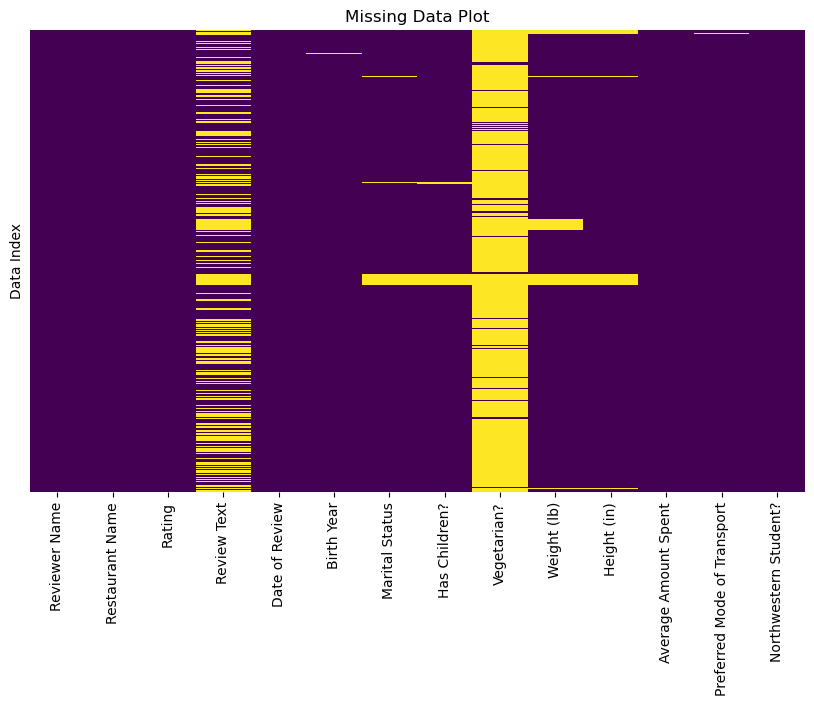

In [8]:
missing_data = reviews.isnull()

# Draw a heatmap
plt.figure(figsize=(10,6))
sns.heatmap(missing_data, cbar=False, yticklabels=False, cmap='viridis')

# Adding title and labels
plt.title('Missing Data Plot')
plt.ylabel('Data Index')
plt.savefig('Image_Lab_2/missing_plot.jpg', bbox_inches='tight')

plt.show()

In [9]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1436 entries, 6 to 1152
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Reviewer Name                1436 non-null   object        
 1   Restaurant Name              1436 non-null   object        
 2   Rating                       1436 non-null   int64         
 3   Review Text                  886 non-null    object        
 4   Date of Review               1436 non-null   datetime64[ns]
 5   Birth Year                   1434 non-null   float64       
 6   Marital Status               1401 non-null   object        
 7   Has Children?                1398 non-null   object        
 8   Vegetarian?                  80 non-null     object        
 9   Weight (lb)                  1339 non-null   float64       
 10  Height (in)                  1382 non-null   float64       
 11  Average Amount Spent         1435 non-null 

In [10]:
missing_values_percentage = (reviews.isnull().sum() / len(reviews)) * 100

# Print the percentage of missing values for each column
print(missing_values_percentage)

Reviewer Name                   0.000000
Restaurant Name                 0.000000
Rating                          0.000000
Review Text                    38.300836
Date of Review                  0.000000
Birth Year                      0.139276
Marital Status                  2.437326
Has Children?                   2.646240
Vegetarian?                    94.428969
Weight (lb)                     6.754875
Height (in)                     3.760446
Average Amount Spent            0.069638
Preferred Mode of Transport     0.278552
Northwestern Student?           0.000000
dtype: float64


## Data Distribution

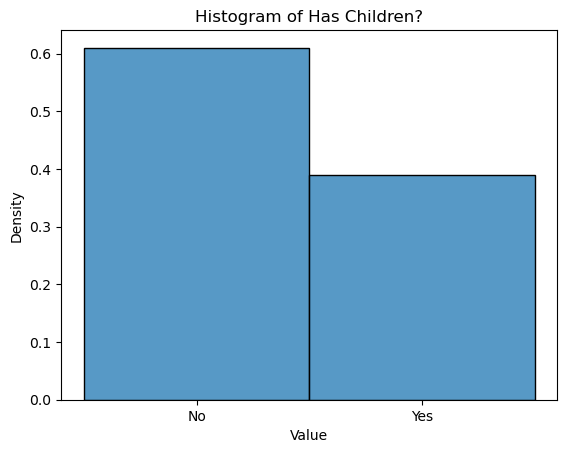

In [11]:
sns.histplot(reviews['Has Children?'].dropna(), stat='density')
plt.title('Histogram of Has Children?')
plt.xlabel('Value')
plt.ylabel('Density')
plt.savefig('Image_Lab_2/haschildren_hist.jpg', bbox_inches='tight')

plt.show()

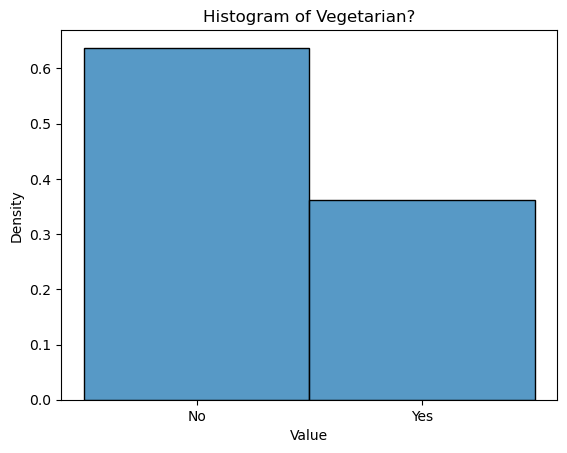

In [12]:
sns.histplot(reviews['Vegetarian?'].dropna(), stat='density')
plt.title('Histogram of Vegetarian?')
plt.xlabel('Value')
plt.ylabel('Density')
plt.savefig('Image_Lab_2/Vegetarian_hist.jpg', bbox_inches='tight')

plt.show()

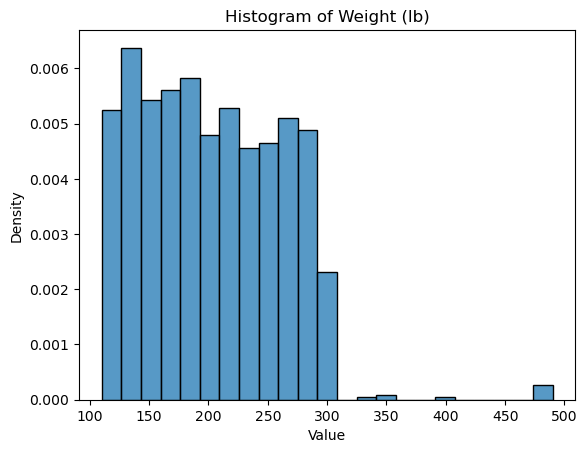

In [13]:
sns.histplot(reviews['Weight (lb)'].dropna(), stat='density')
plt.title('Histogram of Weight (lb)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.savefig('Image_Lab_2/weight_hist.jpg', bbox_inches='tight')

plt.show()

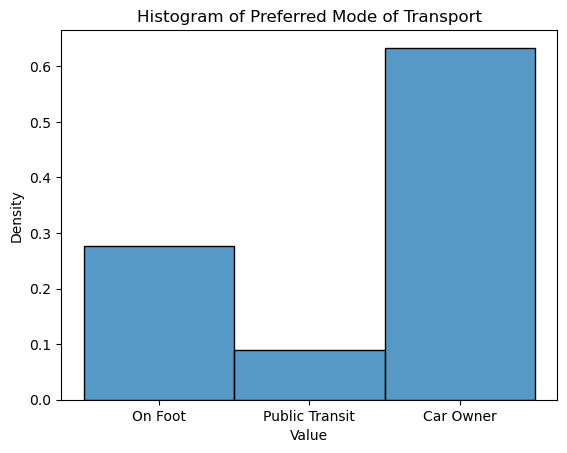

In [14]:
sns.histplot(reviews['Preferred Mode of Transport'].dropna(), stat='density')
plt.title('Histogram of Preferred Mode of Transport')
plt.xlabel('Value')
plt.ylabel('Density')
plt.savefig('Image_Lab_2/Preferred_Mode_of_Transport_hist.jpg', bbox_inches='tight')

plt.show()

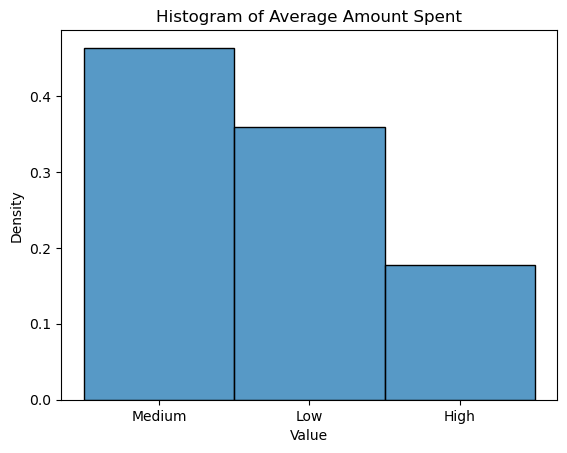

In [15]:
sns.histplot(reviews['Average Amount Spent'].dropna(), stat='density')
plt.title('Histogram of Average Amount Spent')
plt.xlabel('Value')
plt.ylabel('Density')
plt.savefig('Image_Lab_2/Average_Amount_Spent_hist.jpg', bbox_inches='tight')

plt.show()

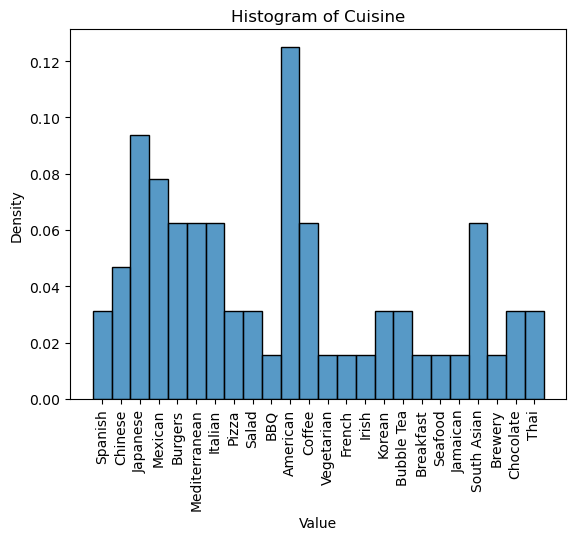

In [16]:
sns.histplot(restaurants['Cuisine'].dropna(), stat='density')
plt.title('Histogram of Cuisine')
plt.xlabel('Value')
plt.ylabel('Density')
plt.xticks(rotation=90)
plt.savefig('Image_Lab_2/Cuisine_hist.jpg', bbox_inches='tight')

plt.show()

## Clustering

In [17]:
categorical_columns = ['Marital Status', 'Has Children?', 'Vegetarian?', 'Average Amount Spent', 
                       'Preferred Mode of Transport', 'Northwestern Student?']

for column in categorical_columns:
    reviews[column].fillna('Missing', inplace=True)

reviews_categorical = reviews[categorical_columns]

# Apply one-hot encoding
encoder = OneHotEncoder(sparse=False)
reviews_encoded = encoder.fit_transform(reviews_categorical)
reviews_encoded = pd.DataFrame(reviews_encoded, columns=encoder.get_feature_names_out(categorical_columns))

/var/folders/67/kpl0tnjd1md6qddgggbqjqyr0000gn/T/ipykernel_61721/3009225122.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews[column].fillna('Missing', inplace=True)
/Users/always/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


K-means

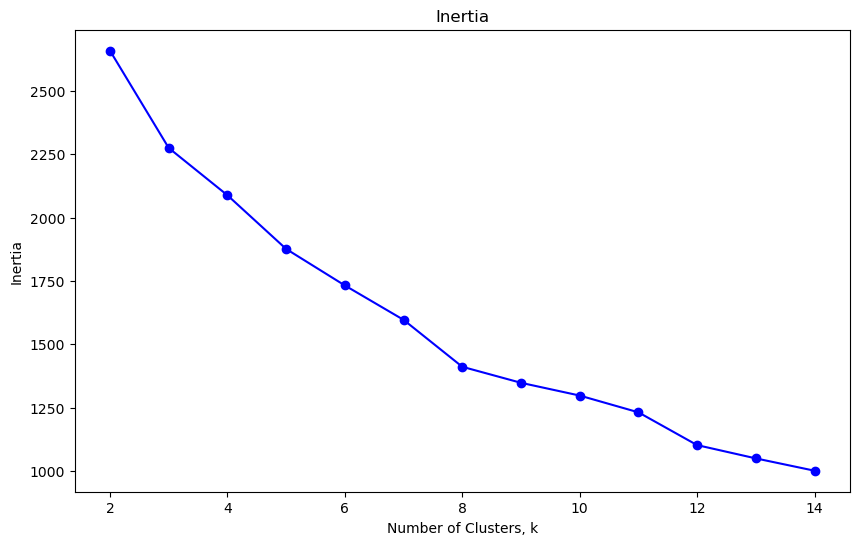

In [18]:
inertias = []

for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto')
    kmeans.fit(reviews_encoded)
    inertias.append(kmeans.inertia_)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(range(2, 15), inertias, 'bo-')
plt.xlabel('Number of Clusters, k')
plt.ylabel('Inertia')
plt.title('Inertia')
plt.savefig('Image_Lab_2/inertia_kmeans.jpg', bbox_inches='tight')
plt.show()

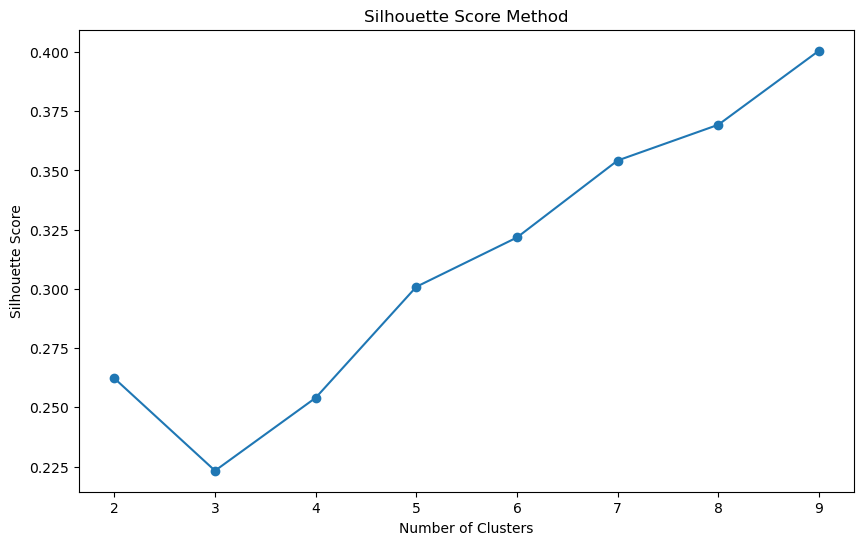

In [19]:
silhouette_scores = []
for i in range(2, 10):
    kmeans = KMeans(n_clusters=i, random_state=3, n_init='auto')
    kmeans.fit(reviews_encoded)
    score = silhouette_score(reviews_encoded, kmeans.labels_)
    silhouette_scores.append(score)
    
plt.figure(figsize=(10, 6))
plt.plot(range(2, 10), silhouette_scores, 'o-')
plt.title('Silhouette Score Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.savefig('Image_Lab_2/Silhouette_kmeans.jpg', bbox_inches='tight')
plt.show()

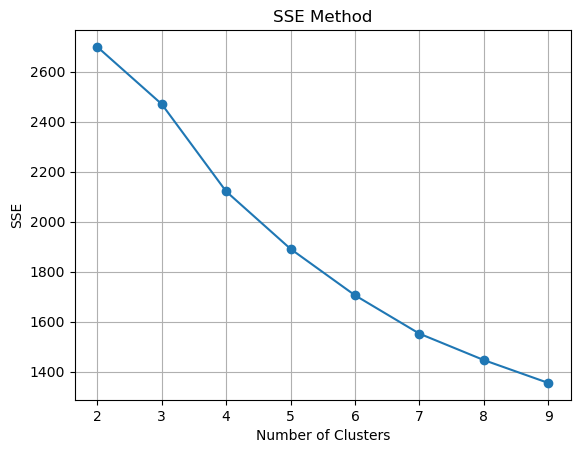

In [20]:
sse = []
for i in range(2, 10):
    kmeans = KMeans(n_clusters=i, random_state=3, n_init='auto')
    kmeans.fit(reviews_encoded)
    sse.append(kmeans.inertia_)

plt.plot(range(2, 10), sse, 'o-')
plt.title('SSE Method')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.grid(True)
plt.show()

In [21]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto')
clusters = kmeans.fit_predict(reviews_encoded)
reviews['Cluster'] = clusters

# Evaluate clustering
score = silhouette_score(reviews_encoded, clusters)
print(f"Silhouette Score: {score}")

# Print cluster characteristics
print(reviews['Cluster'].value_counts())

Silhouette Score: 0.28271182236910325
0    357
2    341
1    320
4    229
3    189
Name: Cluster, dtype: int64


/var/folders/67/kpl0tnjd1md6qddgggbqjqyr0000gn/T/ipykernel_61721/3013894909.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['Cluster'] = clusters


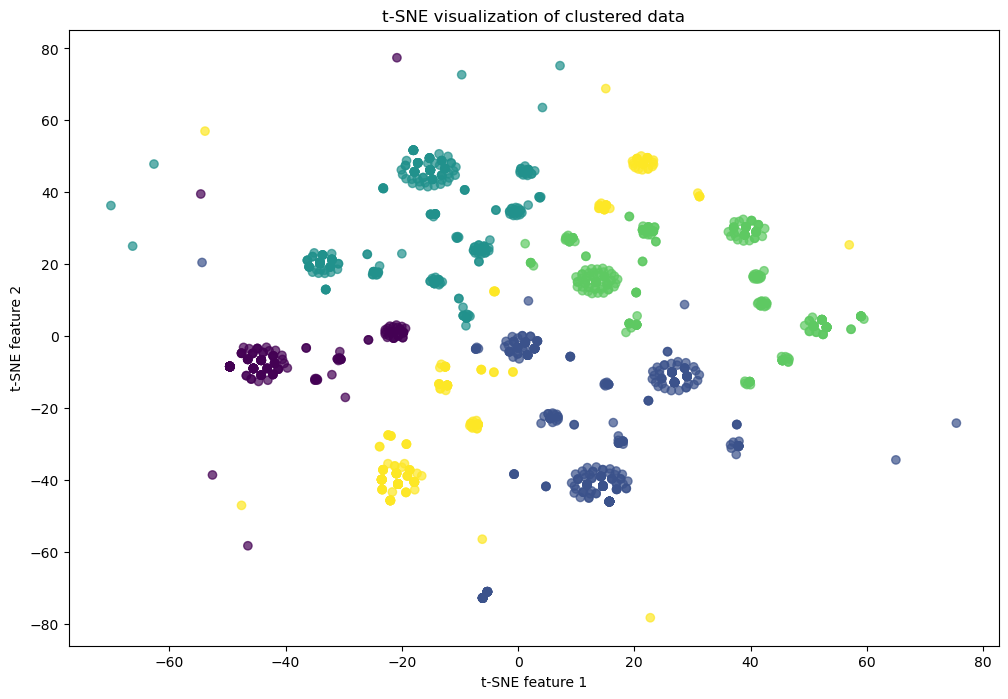

In [22]:
kmeans = KMeans(n_clusters=5, n_init='auto')  # Replace with the optimal number of clusters you've determined
clusters = kmeans.fit_predict(reviews_encoded)

tsne = TSNE(n_components=2, random_state=10)
data_tsne = tsne.fit_transform(reviews_encoded)

# Creating a scatter plot of the t-SNE reduced data
plt.figure(figsize=(12, 8))
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=clusters, cmap='viridis', marker='o', alpha=0.7)

plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.title('t-SNE visualization of clustered data')

plt.savefig('Image_Lab_2/tsne_kmeans.jpg', bbox_inches='tight')
plt.show()

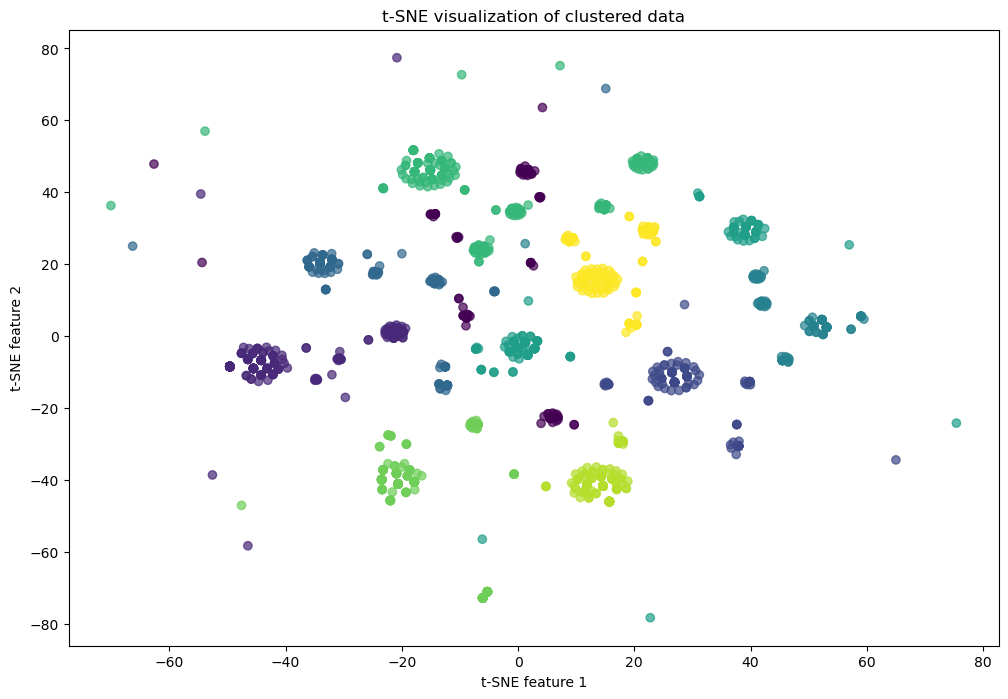

In [23]:
kmeans = KMeans(n_clusters=10, n_init='auto')  # Replace with the optimal number of clusters you've determined
clusters = kmeans.fit_predict(reviews_encoded)

tsne = TSNE(n_components=2, random_state=10)
data_tsne = tsne.fit_transform(reviews_encoded)

# Creating a scatter plot of the t-SNE reduced data
plt.figure(figsize=(12, 8))
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=clusters, cmap='viridis', marker='o', alpha=0.7)

plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.title('t-SNE visualization of clustered data')

plt.savefig('Image_Lab_2/10-tsne_kmeans.jpg', bbox_inches='tight')
plt.show()

In [24]:
cluster_scores = reviews.groupby('Cluster')['Rating'].mean()
print(cluster_scores)

Cluster
0    3.843137
1    3.853125
2    3.873900
3    3.740741
4    3.358079
Name: Rating, dtype: float64


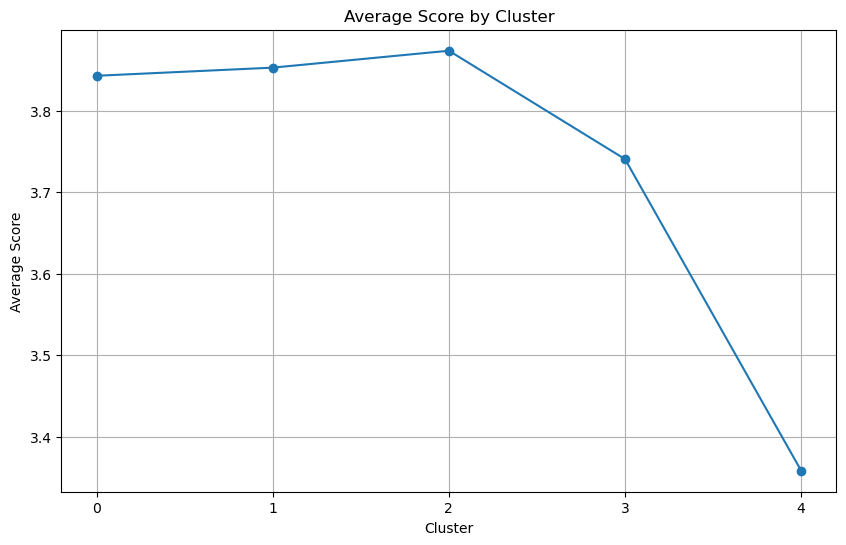

In [25]:
plt.figure(figsize=(10, 6))
cluster_scores.sort_index().plot(kind='line', marker='o')  # Ensure clusters are sorted by index if needed
plt.title('Average Score by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Score')
plt.grid(True)
plt.xticks(cluster_scores.index)  # Ensure x-ticks match cluster labels
plt.show()

DBSACN

In [26]:
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Fit the model
clusters = dbscan.fit_predict(reviews_encoded)

# Add cluster assignments back to the original dataframe
reviews['Cluster'] = clusters

# Check how many unique clusters were created
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise = list(clusters).count(-1)

print(f'Estimated number of clusters: {n_clusters}')
print(f'Estimated number of noise points: {n_noise}')

Estimated number of clusters: 44
Estimated number of noise points: 114


/var/folders/67/kpl0tnjd1md6qddgggbqjqyr0000gn/T/ipykernel_61721/432371824.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['Cluster'] = clusters


In [27]:
cluster_scores = reviews.groupby('Cluster')['Rating'].mean()
print(cluster_scores)

Cluster
-1     3.964912
 0     3.962025
 1     3.409091
 2     3.841270
 3     2.863636
 4     3.983607
 5     4.000000
 6     3.362745
 7     3.900000
 8     3.959732
 9     3.750000
 10    4.294118
 11    3.350000
 12    3.384615
 13    2.900000
 14    3.400000
 15    3.500000
 16    3.870370
 17    4.294118
 18    3.250000
 19    3.750000
 20    4.000000
 21    4.160000
 22    3.368421
 23    3.750000
 24    3.400000
 25    4.619048
 26    3.000000
 27    3.424242
 28    3.533333
 29    3.400000
 30    4.583333
 31    4.000000
 32    3.833333
 33    3.800000
 34    2.200000
 35    2.500000
 36    2.900000
 37    4.285714
 38    4.785714
 39    2.242424
 40    3.400000
 41    3.222222
 42    4.500000
 43    4.100000
Name: Rating, dtype: float64


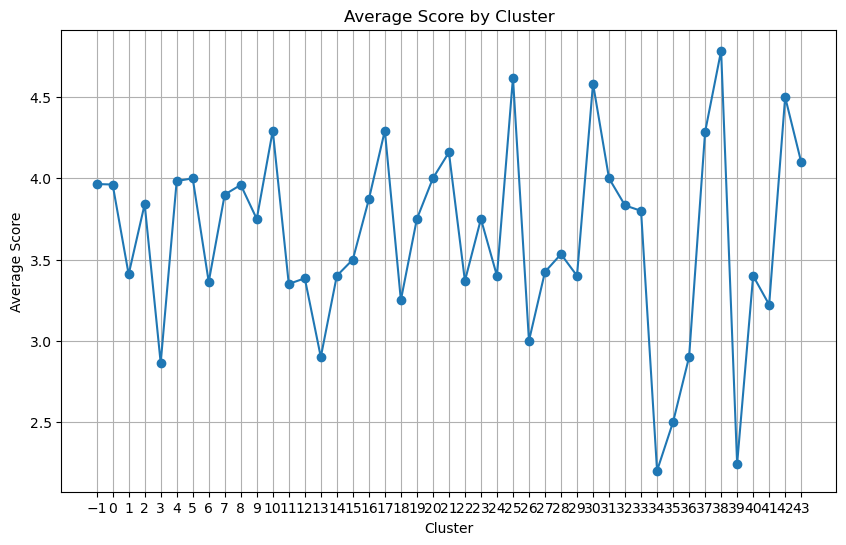

In [28]:
plt.figure(figsize=(10, 6))
cluster_scores.sort_index().plot(kind='line', marker='o')  # Ensure clusters are sorted by index if needed
plt.title('Average Score by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Score')
plt.grid(True)
plt.xticks(cluster_scores.index)  # Ensure x-ticks match cluster labels
plt.show()

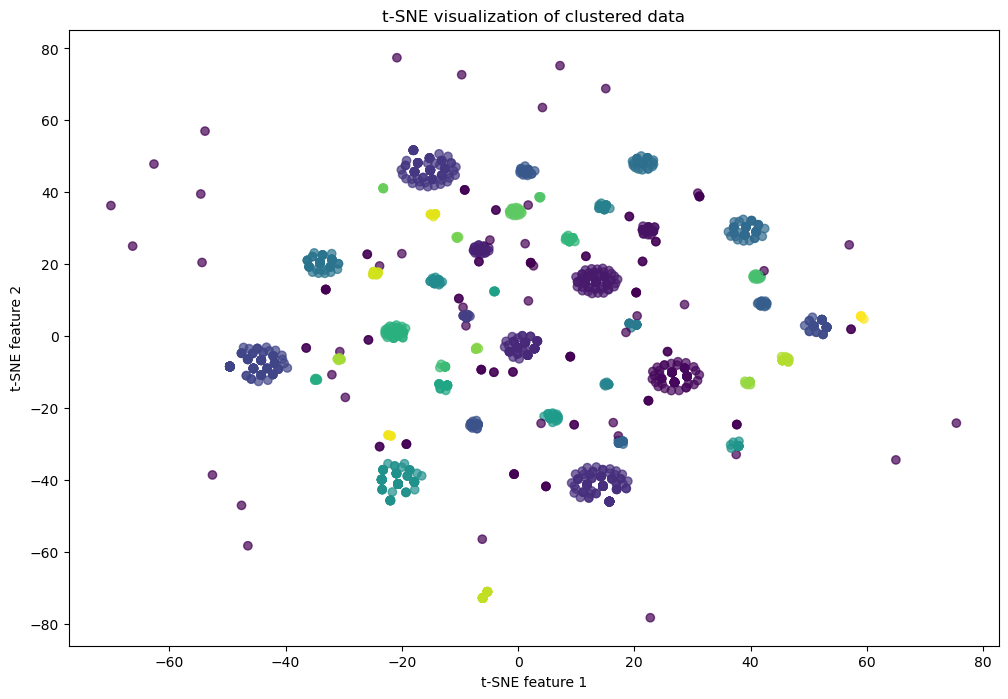

In [29]:
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Fit the model
clusters = dbscan.fit_predict(reviews_encoded)

tsne = TSNE(n_components=2, random_state=10)
data_tsne = tsne.fit_transform(reviews_encoded)

# Creating a scatter plot of the t-SNE reduced data
plt.figure(figsize=(12, 8))
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=clusters, cmap='viridis', marker='o', alpha=0.7)

plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.title('t-SNE visualization of clustered data')
plt.savefig('Image_Lab_2/tsne_dbscan.jpg', bbox_inches='tight')

plt.show()

Agglomerative Clustering

In [30]:
agg_clustering = AgglomerativeClustering(n_clusters=10, metric='euclidean', linkage='ward')

# Fit the model
clusters = agg_clustering.fit_predict(reviews_encoded)

# Add cluster assignments back to the original dataframe
reviews['Cluster'] = clusters

/var/folders/67/kpl0tnjd1md6qddgggbqjqyr0000gn/T/ipykernel_61721/316254860.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['Cluster'] = clusters


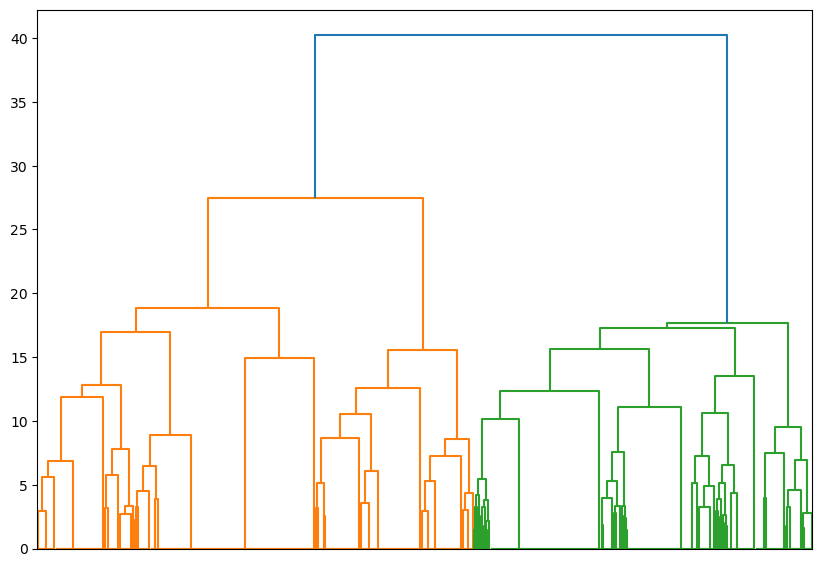

In [31]:
# Use the linkage matrix to perform hierarchical clustering
linked = linkage(reviews_encoded, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', labels=clusters, distance_sort='descending', show_leaf_counts=True, no_labels=True)
plt.savefig('Image_Lab_2/dendrogram.jpg', bbox_inches='tight')
plt.show()

In [32]:
cluster_scores = reviews.groupby('Cluster')['Rating'].mean()
print(cluster_scores)

Cluster
0    3.235294
1    3.463687
2    3.918455
3    4.050505
4    3.490566
5    4.160000
6    3.981308
7    3.598684
8    3.673469
9    4.000000
Name: Rating, dtype: float64


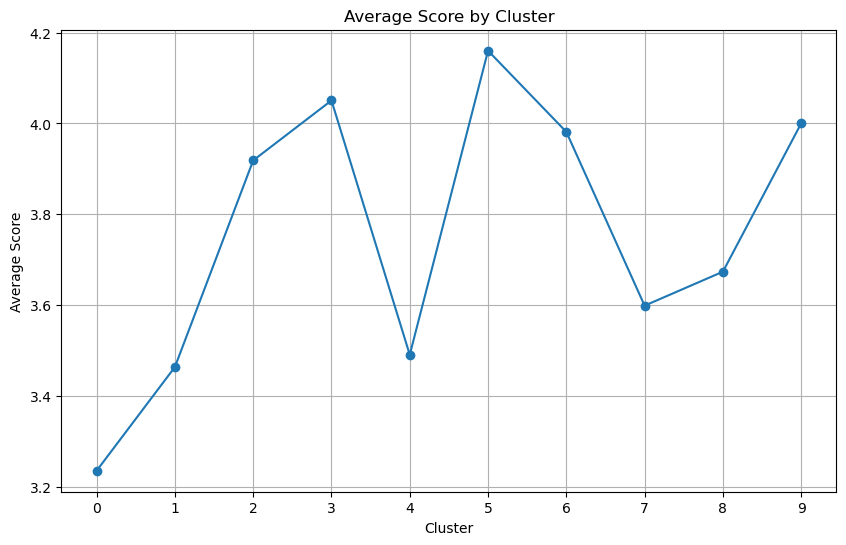

In [33]:
plt.figure(figsize=(10, 6))
cluster_scores.sort_index().plot(kind='line', marker='o')  # Ensure clusters are sorted by index if needed
plt.title('Average Score by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Score')
plt.grid(True)
plt.xticks(cluster_scores.index)  # Ensure x-ticks match cluster labels
plt.savefig('Image_Lab_2/trend_cluster.jpg', bbox_inches='tight')
plt.show()

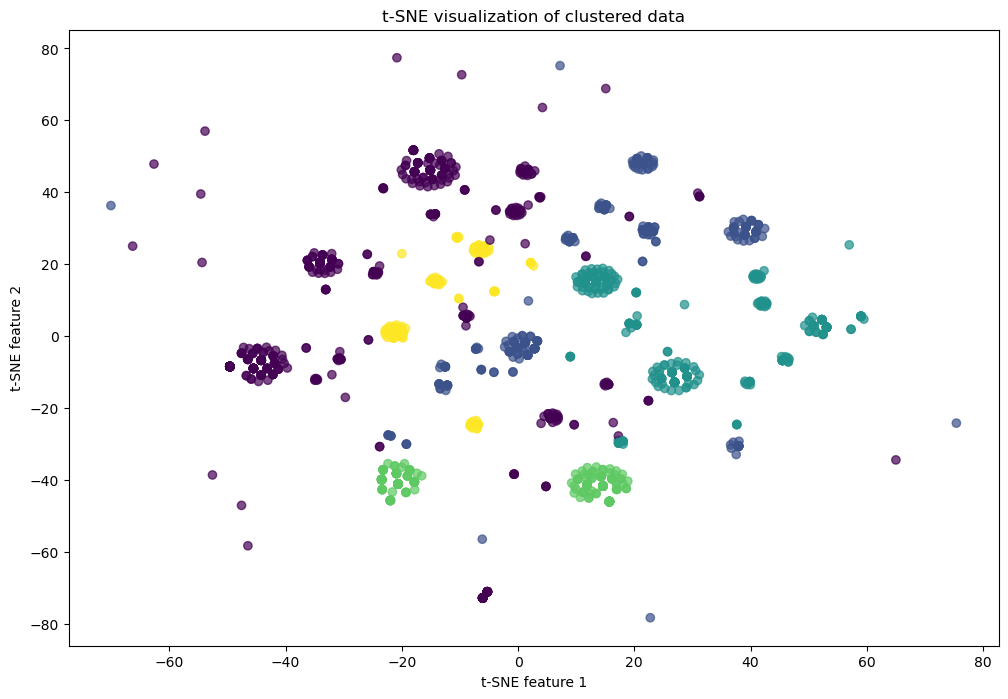

In [34]:
agg_clustering = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward')

# Fit the model
clusters = agg_clustering.fit_predict(reviews_encoded)

tsne = TSNE(n_components=2, random_state=10)
data_tsne = tsne.fit_transform(reviews_encoded)

# Creating a scatter plot of the t-SNE reduced data
plt.figure(figsize=(12, 8))
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=clusters, cmap='viridis', marker='o', alpha=0.7)

plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.title('t-SNE visualization of clustered data')
plt.savefig('Image_Lab_2/5_agg_tsne.jpg', bbox_inches='tight')

plt.show()

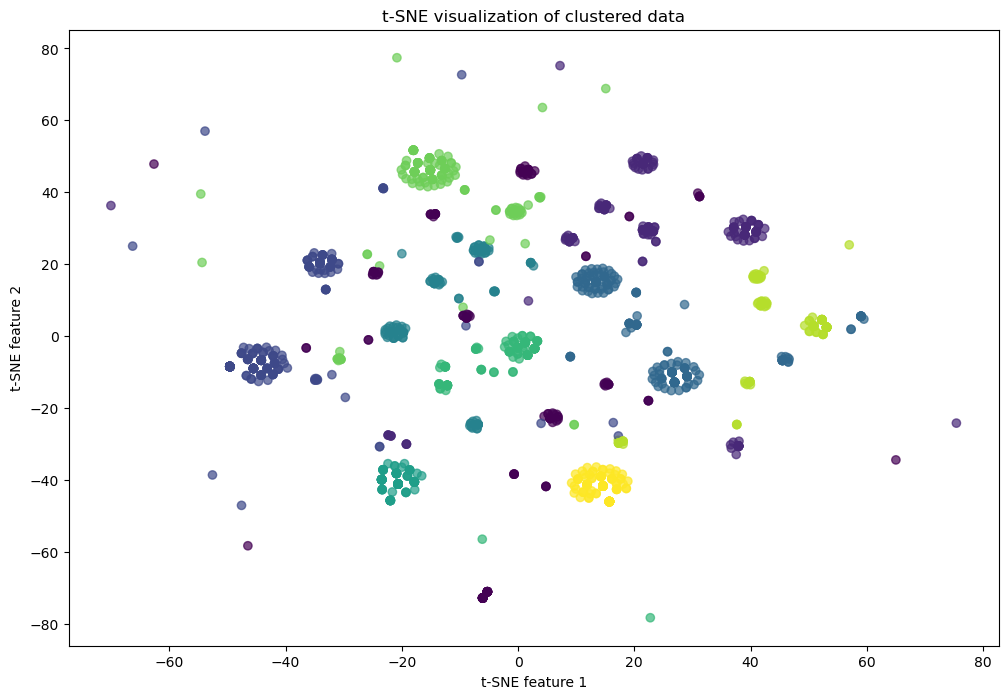

In [35]:
agg_clustering = AgglomerativeClustering(n_clusters=10, metric='euclidean', linkage='ward')

# Fit the model
clusters = agg_clustering.fit_predict(reviews_encoded)

tsne = TSNE(n_components=2, random_state=10)
data_tsne = tsne.fit_transform(reviews_encoded)

# Creating a scatter plot of the t-SNE reduced data
plt.figure(figsize=(12, 8))
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=clusters, cmap='viridis', marker='o', alpha=0.7)

plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.title('t-SNE visualization of clustered data')
plt.savefig('Image_Lab_2/10_agg_tsne.jpg', bbox_inches='tight')

plt.show()

# Popularity Matching

## 4) Identify the restaurant with the highest average review score, report its average score, and compare it to the general dataset's average score. Additionally, find the restaurant that has received the highest number of reviews and compare this number to the dataset's median number of reviews in your report.

In [36]:
overall_mean_rating = reviews['Rating'].mean()
overall_mean_rating

3.7618384401114207

In [37]:
reviews.head()

,Reviewer Name,Restaurant Name,Rating,Review Text,Date of Review,Birth Year,Marital Status,Has Children?,Vegetarian?,Weight (lb),Height (in),Average Amount Spent,Preferred Mode of Transport,Northwestern Student?,Cluster
6,A B,Graduate Homestead Room,2,"Good service, beautiful interior but the food,...",2023-01-11,1998.0,Single,No,Missing,NaN,NaN,Medium,On Foot,No,3
8,A B,Panino's Pizzeria,2,NaN,2023-01-03,1998.0,Single,No,Missing,NaN,NaN,Medium,On Foot,No,3
4,A B,Edzo's Burger Shop,5,Second best burger in Evanston,2022-11-28,1998.0,Single,No,Missing,NaN,NaN,Medium,On Foot,No,3
1,A B,Barn Steakhouse,5,Excellent meal in a warm atmosphere! The space...,2022-11-22,1998.0,Single,No,Missing,NaN,NaN,Medium,On Foot,No,3
3,A B,Clarkes Off Campus,5,Best burger in Evanston,2022-10-30,1998.0,Single,No,Missing,NaN,NaN,Medium,On Foot,No,3


In [38]:
average_ratings = reviews.groupby('Restaurant Name')['Rating'].mean().reset_index()

# Rename the columns for clarity
average_ratings.columns = ['Restaurant Name', 'Average Rating']
average_ratings

,Restaurant Name,Average Rating
0,5411 Empanadas,3.703704
1,Alcove,3.631579
2,Barn Steakhouse,4.000000
3,Brothers K Coffeehouse,4.533333
4,Burger King,1.800000
...,...,...
63,Trattoria DOC,3.269231
64,Trattoria Demi,3.307692
65,Union Pizzeria,4.212121
66,World Market,5.000000


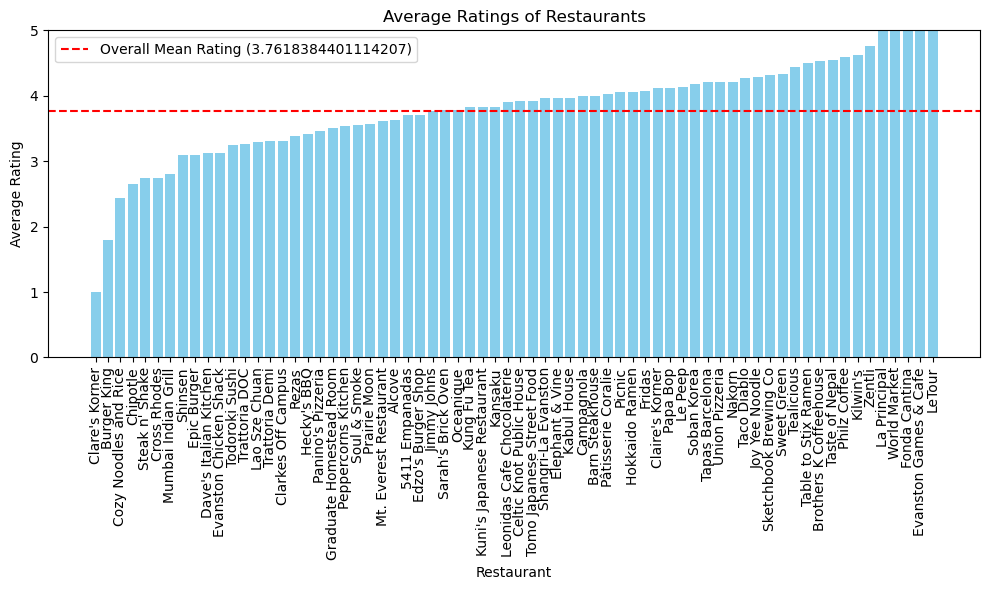

In [39]:
average_ratings = average_ratings.sort_values('Average Rating')

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(average_ratings['Restaurant Name'], average_ratings['Average Rating'], color='skyblue')
plt.xlabel('Restaurant')
plt.ylabel('Average Rating')
plt.title('Average Ratings of Restaurants')
plt.ylim(0, 5)  # Assuming ratings are on a scale of 1 to 5
plt.xticks(rotation=90)  # Rotate the x-axis labels to show them more clearly
plt.axhline(y=overall_mean_rating, color='red', linewidth=1.5, linestyle='--', label=f'Overall Mean Rating ({overall_mean_rating})')
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.legend()
plt.savefig('Image_Lab_2/average_score_total.jpg', bbox_inches='tight')
plt.show()

In [40]:
rating_frequency = reviews['Restaurant Name'].value_counts().reset_index()
rating_frequency.columns = ['Restaurant Name', 'Frequency']
rating_frequency

,Restaurant Name,Frequency
0,Campagnola,48
1,Chipotle,41
2,Cozy Noodles and Rice,37
3,Taco Diablo,36
4,Tealicious,34
...,...,...
63,Todoroki Sushi,4
64,World Market,2
65,La Principal,1
66,Evanston Games & Cafe,1


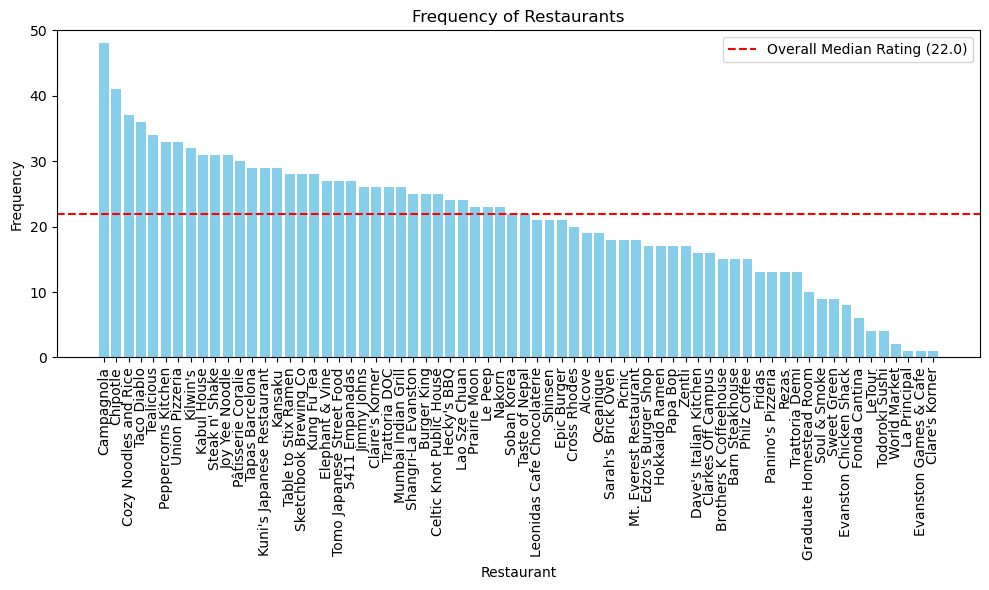

In [41]:
rate_median = rating_frequency['Frequency'].median()
# Plotting
plt.figure(figsize=(10, 6))
plt.bar(rating_frequency['Restaurant Name'], rating_frequency['Frequency'], color='skyblue')
plt.xlabel('Restaurant')
plt.ylabel('Frequency')
plt.title('Frequency of Restaurants')
plt.ylim(0, 50)  # Assuming ratings are on a scale of 1 to 5
plt.xticks(rotation=90)  # Rotate the x-axis labels to show them more clearly
plt.axhline(y=rate_median, color='red', linewidth=1.5, linestyle='--', label=f'Overall Median Rating ({rate_median})')
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.legend()
plt.savefig('Image_Lab_2/rate_freq.jpg', bbox_inches='tight')
plt.show()

## 5) Create a simple recommendation engine that offers restaurant suggestions based on a specific cuisine type entered by a user, based on a popularity score. Apply this engine to generate recommendations for Spanish, Chinese, Mexican food, and Coffee, and include these specific recommendations in your report.

In [42]:
merged_df = pd.merge(restaurants[['Restaurant Name', 'Cuisine']], reviews, on='Restaurant Name')
merged_df.head()

,Restaurant Name,Cuisine,Reviewer Name,Rating,Review Text,Date of Review,Birth Year,Marital Status,Has Children?,Vegetarian?,Weight (lb),Height (in),Average Amount Spent,Preferred Mode of Transport,Northwestern Student?,Cluster
0,Tapas Barcelona,Spanish,Arek Gazda,5,Tapas done the right way! What a great experie...,2023-02-22,1967.0,Widow,No,Missing,120.0,161.0,Low,Car Owner,No,0
1,Tapas Barcelona,Spanish,Ben,5,Amazing food,2018-04-11,1980.0,Married,No,No,154.0,178.0,High,Car Owner,No,6
2,Tapas Barcelona,Spanish,Charles Stop,3,"Service was great. However, food was not that ...",2022-11-22,1991.0,Single,No,Missing,178.0,187.0,Low,Car Owner,No,1
3,Tapas Barcelona,Spanish,Dennis Folse,2,NaN,2022-09-13,1987.0,Married,Yes,Missing,233.0,172.0,Medium,On Foot,No,4
4,Tapas Barcelona,Spanish,Derek B,4,NaN,2022-01-11,1956.0,Married,Yes,Missing,131.0,123.0,Medium,On Foot,No,4


In [43]:
def recommendation_popularity(cuisine, data = merged_df):
    temp_data = data[data['Cuisine'] == cuisine]
    mu_s = temp_data['Rating'].mean()
    temp_average_scores = temp_data.groupby('Restaurant Name')['Rating'].mean().reset_index()
    temp_average_scores.columns = ['Restaurant Name', 'Average Score']
    temp_average_scores = temp_average_scores.sort_values('Restaurant Name', ascending=True)
    temp_average_scores.index = range(0, len(temp_average_scores['Restaurant Name']))
    mu_p = temp_average_scores['Average Score']
    
    temp_frequency = temp_data['Restaurant Name'].value_counts().reset_index()
    temp_frequency.columns = ['Restaurant Name', 'Frequency']
    temp_frequency = temp_frequency.sort_values('Restaurant Name', ascending=True)
    temp_frequency.index = range(0, len(temp_average_scores['Restaurant Name']))
    N_mu = temp_frequency['Frequency'].mean()
    
    alpha = np.minimum(temp_frequency['Frequency'] / N_mu, 1)
    result = (1 - alpha) * mu_s + alpha * mu_p
    
    final_df = pd.DataFrame({'Restaurant Name': temp_frequency['Restaurant Name'], 'Shrinkage Estimator': result})
    final_df = final_df.sort_values('Shrinkage Estimator', ascending=False)
    final_df.index = range(0, len(temp_average_scores['Restaurant Name']))
    
    return final_df

In [44]:
recommendation_popularity('Spanish')

,Restaurant Name,Shrinkage Estimator
0,Tapas Barcelona,4.206897
1,5411 Empanadas,3.713010


In [45]:
recommendation_popularity('Chinese')

,Restaurant Name,Shrinkage Estimator
0,Joy Yee Noodle,4.290323
1,Peppercorns Kitchen,3.545455
2,Lao Sze Chuan,3.372934


In [46]:
recommendation_popularity('Coffee')

,Restaurant Name,Shrinkage Estimator
0,Philz Coffee,4.595270
1,Brothers K Coffeehouse,4.529696
2,Evanston Games & Cafe,4.356625
3,Pâtisserie Coralie,4.033333


In [47]:
recommendation_popularity('Mexican')

,Restaurant Name,Shrinkage Estimator
0,Zentli,4.520401
1,Taco Diablo,4.277778
2,Fonda Cantina,4.102984
3,Fridas,3.950270
4,Chipotle,2.658537


## 6) Implement a shrinkage estimator that adjusts review scores towards the mean score, scaled by the number of reviews a restaurant has received. Please use the exact shrinkage estimator from page 17 of Lecture 4. Identify the restaurant that benefits the most from this adjustment and the one that is most negatively affected. Illustrate the impact of shrinkage on review scores. For example, you can plot the top positive and negative changes in a bar chart, but feel free to create an alternative plot if you prefer, or present your results in a table instead.

In [48]:
temp_data = merged_df

mu_s = temp_data['Rating'].mean()
temp_average_scores = temp_data.groupby('Restaurant Name')['Rating'].mean().reset_index()
temp_average_scores.columns = ['Restaurant Name', 'Average Score']
temp_average_scores = temp_average_scores.sort_values('Restaurant Name', ascending=True)
temp_average_scores.index = range(0, len(temp_average_scores['Restaurant Name']))
mu_p = temp_average_scores['Average Score']
    
temp_frequency = temp_data['Restaurant Name'].value_counts().reset_index()
temp_frequency.columns = ['Restaurant Name', 'Frequency']
temp_frequency = temp_frequency.sort_values('Restaurant Name', ascending=True)
temp_frequency.index = range(0, len(temp_average_scores['Restaurant Name']))
N_mu = temp_frequency['Frequency'].mean()
    
result = (N_mu * mu_s + temp_frequency['Frequency'] * mu_p)/(N_mu + temp_frequency['Frequency'])


final_df = pd.DataFrame({'Restaurant Name': temp_frequency['Restaurant Name'], 'Shrinkage Estimator': result})
final_df = final_df.sort_values('Shrinkage Estimator', ascending=False)
final_df.index = range(0, len(temp_average_scores['Restaurant Name']))

In [49]:
final_ordered = final_df.sort_values('Restaurant Name', ascending=True).reset_index()
diff = final_ordered['Shrinkage Estimator'] - temp_average_scores['Average Score']
diff_df = pd.DataFrame({'Restaurant Name': final_ordered['Restaurant Name'], 'Diff': diff})

In [50]:
diff_df['Adjusted Difference'] = diff_df['Diff'].abs()
diff_df['Color'] = ['blue' if x >= 0 else 'red' for x in diff_df['Diff']]
diff_df['Label'] = ['Positive' if x >= 0 else 'Negative' for x in diff_df['Diff']]

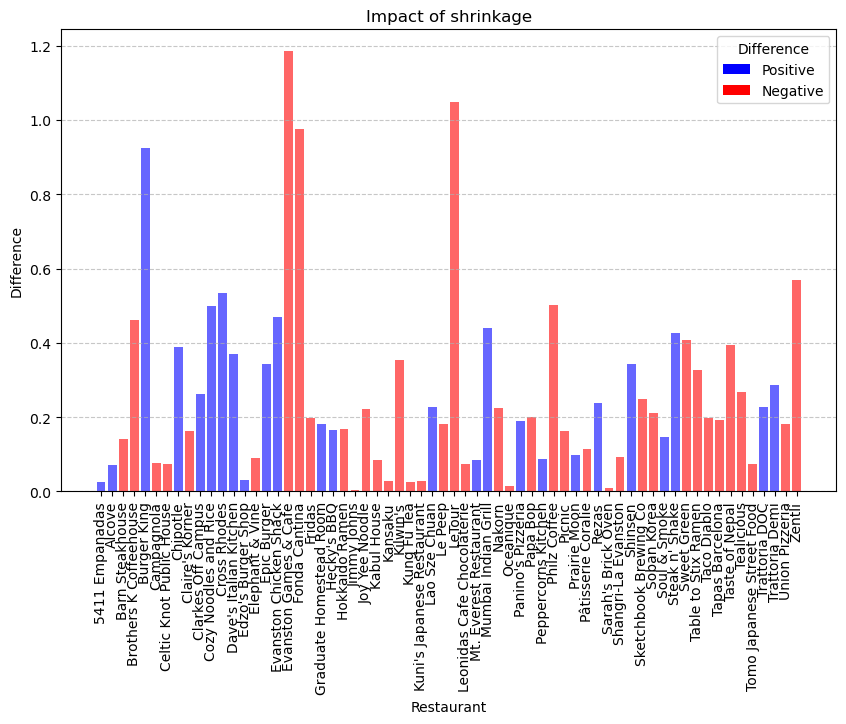

In [51]:
plt.figure(figsize=(10, 6))
for i in range(len(diff_df)):
    plt.bar(diff_df['Restaurant Name'][i], diff_df['Adjusted Difference'][i], color=diff_df['Color'][i], label=diff_df['Label'][i], alpha=0.6)

legend_handles = [Patch(facecolor='blue', label='Positive'), Patch(facecolor='red', label='Negative')]

# Add legend to the plot
plt.legend(handles=legend_handles, title="Difference")

plt.xlabel('Restaurant')
plt.ylabel('Difference')
plt.title('Impact of shrinkage')
plt.xticks(rotation=90)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.savefig('Image_Lab_2/effect_pop.jpg', bbox_inches='tight')
plt.show()

# Content-based Filtering

## 7) Using the data in the "restaurants.csv" table, compute the Euclidean distance between every restaurant. Note that you will need to compute a numeric embedding of the categorical variables.

In [52]:
restaurants.head()

,Restaurant Name,Cuisine,Latitude,Longitude,Average Cost,Open After 8pm?,Brief Description
0,Tapas Barcelona,Spanish,42.046736,-87.679043,20,Yes,"Festive, warm space known for Spanish small pl..."
1,Lao Sze Chuan,Chinese,42.048462,-87.679476,20,Yes,"Modern Chinese mainstay, known for an extensiv..."
2,5411 Empanadas,Spanish,42.047310,-87.681849,13,Yes,Known for Argentinean empanadas & special sauc...
3,Hokkaido Ramen,Japanese,42.048482,-87.682722,13,Yes,"Whimsical ramen bar, known for sushi rolls and..."
4,Tomo Japanese Street Food,Japanese,42.049612,-87.682046,20,Yes,Japanese street food cafe with mobile app orde...


In [53]:
restaurants['Longitude'] = restaurants['Longitude'].astype(str).str.replace(', ', '').str.strip()
restaurants['Longitude'] = pd.to_numeric(restaurants['Longitude'])

In [54]:
categorical_columns = ['Cuisine', 'Open After 8pm?']
restaurants_categorical = restaurants[categorical_columns]

encoder = OneHotEncoder(sparse=False)
restaurants_encoded = encoder.fit_transform(restaurants_categorical)
restaurants_encoded = pd.DataFrame(restaurants_encoded, columns=encoder.get_feature_names_out(categorical_columns))

/Users/always/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [55]:
restaurants_update = restaurants.drop(['Cuisine', 'Open After 8pm?', 'Brief Description'], axis = 1)
restaurants_update = pd.concat([restaurants_update, restaurants_encoded], axis=1)
#restaurants_update.head()

In [56]:
scaler = StandardScaler()

restaurants_update[['Latitude', 'Longitude', 'Average Cost']] = scaler.fit_transform(restaurants_update[['Latitude', 'Longitude', 'Average Cost']])
restaurants_update.head()

,Restaurant Name,Latitude,Longitude,Average Cost,Cuisine_American,Cuisine_BBQ,Cuisine_Breakfast,Cuisine_Brewery,Cuisine_Bubble Tea,Cuisine_Burgers,...,Cuisine_Mexican,Cuisine_Pizza,Cuisine_Salad,Cuisine_Seafood,Cuisine_South Asian,Cuisine_Spanish,Cuisine_Thai,Cuisine_Vegetarian,Open After 8pm?_No,Open After 8pm?_Yes
0,Tapas Barcelona,0.150532,0.623027,0.029921,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,Lao Sze Chuan,0.399969,0.573367,0.029921,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,5411 Empanadas,0.233510,0.301155,-0.807862,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,Hokkaido Ramen,0.402829,0.200993,-0.807862,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,Tomo Japanese Street Food,0.566252,0.278602,0.029921,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [57]:
# Extract numerical data for distance calculation
numerical_data = restaurants_update.iloc[:, 1:]

# Compute pairwise Euclidean distances
distances_euclidean = pdist(numerical_data, metric='euclidean')

# Convert distance vector to a square matrix
distance_matrix_euclidean = squareform(distances_euclidean)

# Create a DataFrame for the distance matrix
distance_df_euclidean = pd.DataFrame(distance_matrix_euclidean, index=restaurants_update['Restaurant Name'], columns=restaurants_update['Restaurant Name'])

# Display the distance matrix DataFrame
#print(distance_df_euclidean)

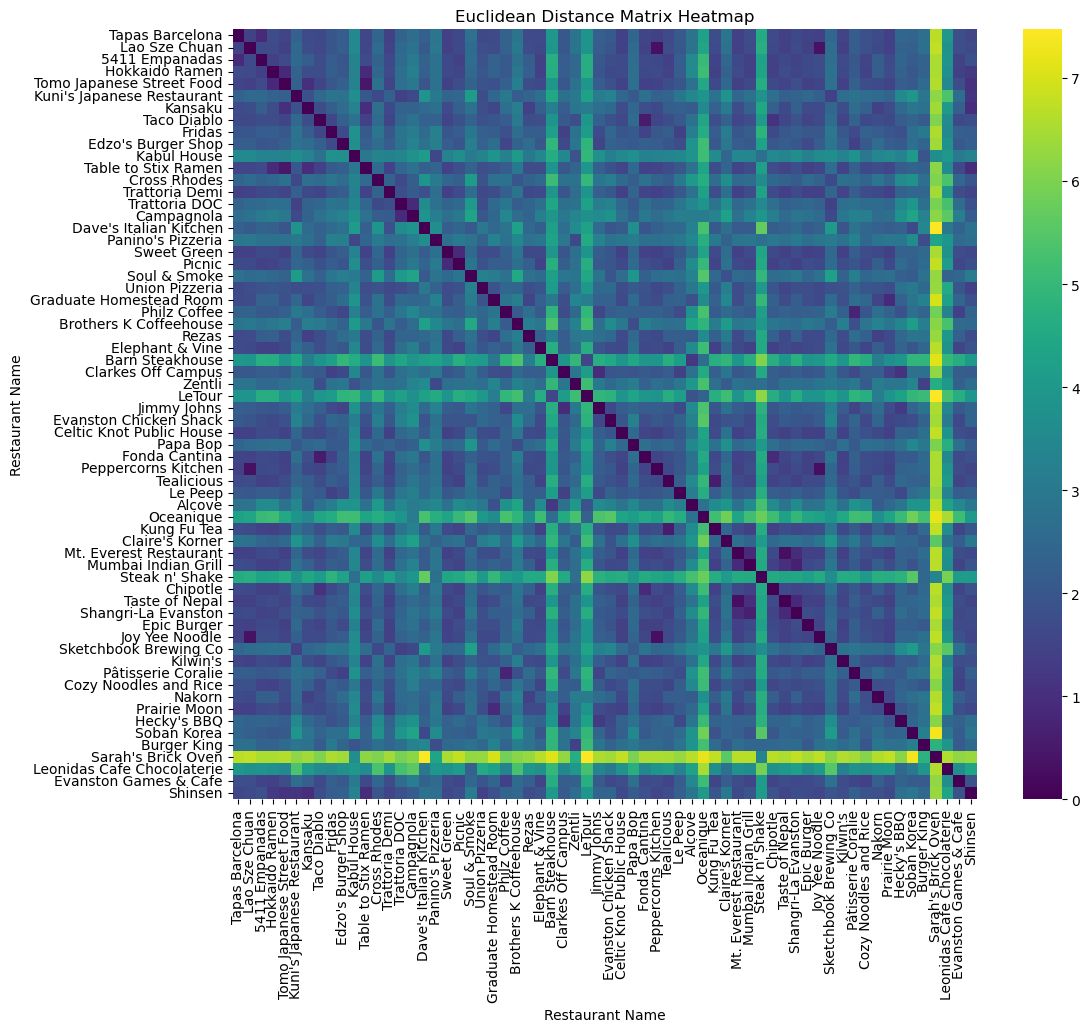

In [58]:
plt.figure(figsize=(12, 10))  # Increase the figure size for better visibility
sns.heatmap(distance_df_euclidean, cmap='viridis', xticklabels=True, yticklabels=True)
plt.title('Euclidean Distance Matrix Heatmap')
plt.savefig('Image_Lab_2/heat_Euclidean.jpg', bbox_inches='tight')
plt.show()

## 8) Repeat the previous step, using cosine distance this time. Then, for both the Euclidean distances and cosine similarities, report the results for the pairs ('Peppercorns Kitchen', 'Epic Burger') and ('Peppercorns Kitchen', 'Lao Sze Chuan'). Discuss how these metrics reflect the relationships and similarities between the restaurants, considering their cuisine types and other features.

In [59]:
# Compute pairwise Euclidean distances
distances_cos = pdist(numerical_data, metric='cosine')

# Convert distance vector to a square matrix
distance_matrix_cos = squareform(distances_cos)

# Create a DataFrame for the distance matrix
distance_df_cos = pd.DataFrame(distance_matrix_cos, index=restaurants_update['Restaurant Name'], columns=restaurants_update['Restaurant Name'])

# Display the distance matrix DataFrame
#print(distance_df_cos)

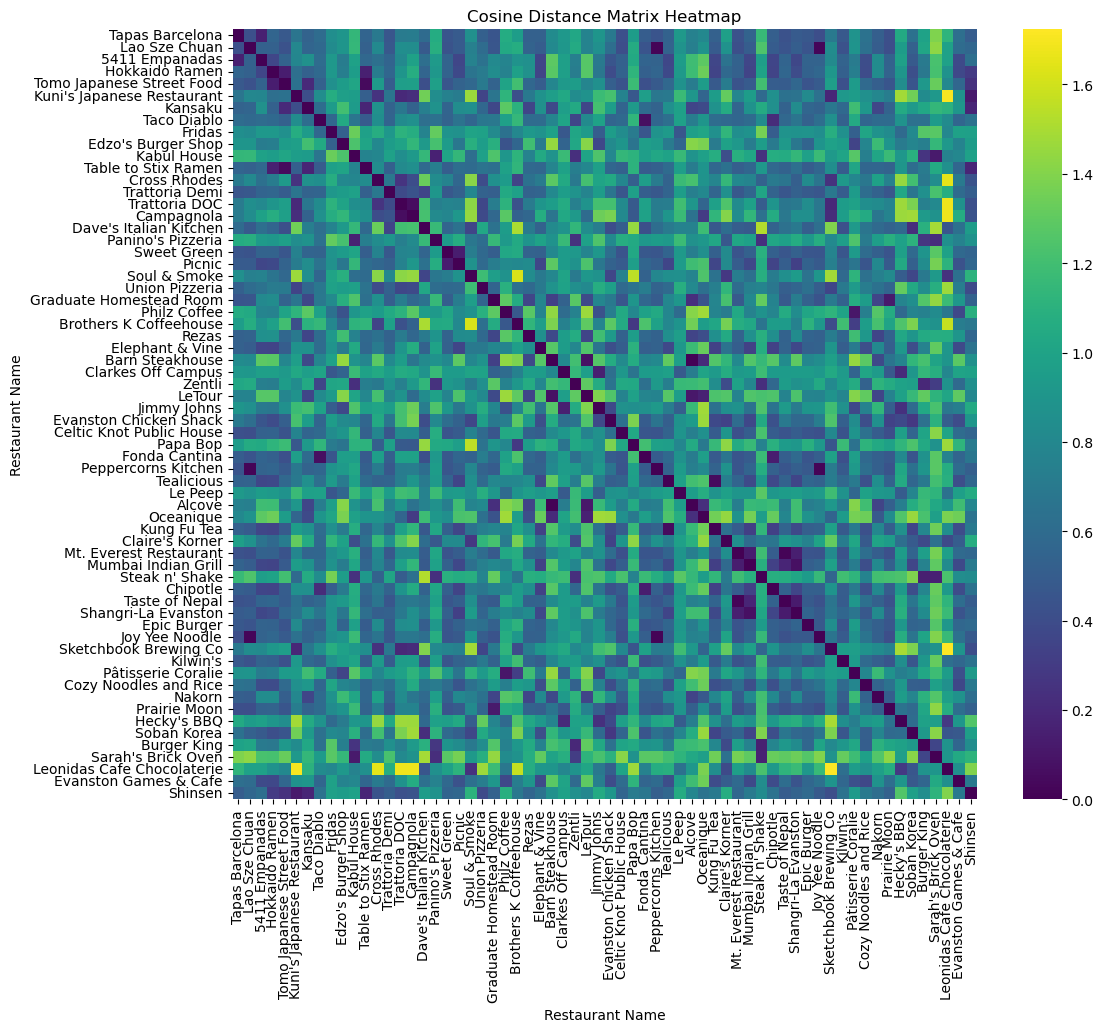

In [60]:
plt.figure(figsize=(12, 10))  # Increase the figure size for better visibility
sns.heatmap(distance_df_cos, cmap='viridis', xticklabels=True, yticklabels=True)
plt.title('Cosine Distance Matrix Heatmap')
plt.savefig('Image_Lab_2/heat_cosine.jpg', bbox_inches='tight')
plt.show()

In [61]:
dis_euclidean_pep_to_epic = distance_df_euclidean.loc['Peppercorns Kitchen', 'Epic Burger']
print("The Euclidean distance between Peppercorns Kitchen and Epic Burger is:", dis_euclidean_pep_to_epic)

dis_cos_pep_to_epic = distance_df_cos.loc['Peppercorns Kitchen', 'Epic Burger']
print("The cosine distance between Peppercorns Kitchen and Epic Burger is:", dis_cos_pep_to_epic)

The Euclidean distance between Peppercorns Kitchen and Epic Burger is: 1.4362319734458955
The cosine distance between Peppercorns Kitchen and Epic Burger is: 0.47160518737255575


In [62]:
dis_euclidean_pep_to_LSC = distance_df_euclidean.loc['Peppercorns Kitchen', 'Lao Sze Chuan']
print("The Euclidean distance between Peppercorns Kitchen and Lao Sze Chuan is:", dis_euclidean_pep_to_LSC)

dis_cos_pep_to_LSC = distance_df_cos.loc['Peppercorns Kitchen', 'Lao Sze Chuan']
print("The cosine distance between Peppercorns Kitchen and Lao Sze Chuan is:", dis_cos_pep_to_LSC)

The Euclidean distance between Peppercorns Kitchen and Lao Sze Chuan is: 0.3151110860116991
The cosine distance between Peppercorns Kitchen and Lao Sze Chuan is: 0.019158302811825068


In [63]:
restaurants_update[restaurants_update['Restaurant Name'].isin(['Peppercorns Kitchen', 'Lao Sze Chuan', 'Epic Burger'])]

,Restaurant Name,Latitude,Longitude,Average Cost,Cuisine_American,Cuisine_BBQ,Cuisine_Breakfast,Cuisine_Brewery,Cuisine_Bubble Tea,Cuisine_Burgers,...,Cuisine_Mexican,Cuisine_Pizza,Cuisine_Salad,Cuisine_Seafood,Cuisine_South Asian,Cuisine_Spanish,Cuisine_Thai,Cuisine_Vegetarian,Open After 8pm?_No,Open After 8pm?_Yes
1,Lao Sze Chuan,0.399969,0.573367,0.029921,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
36,Peppercorns Kitchen,0.131303,0.408705,0.029921,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
49,Epic Burger,0.339519,0.269392,0.029921,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [64]:
squareform(pdist([[0.399969, 0.573367], [0.131303,	0.408705], [0.339519, 0.269392]], metric='euclidean'))

array([[0.        , 0.31511108, 0.30992742],
       [0.31511108, 0.        , 0.25052348],
       [0.30992742, 0.25052348, 0.        ]])

In [65]:
squareform(pdist([[0.399969, 0.573367], [0.131303,	0.408705], [0.339519, 0.269392]], metric='cosine'))

array([[0.        , 0.04414742, 0.04203147],
       [0.04414742, 0.        , 0.16862006],
       [0.04203147, 0.16862006, 0.        ]])

## 9) Write a script for a content-based filtering recommendation engine. This script should accept a user's name, identify the user's favorite restaurant, and then find the 10 most similar restaurants based on Euclidean distance. For the user 'Willie Jacobsen', utilize the engine to identify his favorite restaurant and list the top 10 most similar restaurants. Display these recommendations through a plot, a table, or any other method that shows the system's output effectively.

In [66]:
def content_based_recommendation(user_name, distance_df = distance_df_euclidean, df_reviews = reviews, n = 10):
    review_user = df_reviews[df_reviews['Reviewer Name'] == user_name]
    restaurant_name = review_user[review_user['Rating'] == review_user['Rating'].max()]['Restaurant Name']
    
    for name in restaurant_name.values:
        if name in set(restaurants['Restaurant Name']):
            restaurant_name = name
            break
    
    result = distance_df[restaurant_name].sort_values(ascending=True)

    return result[1:(n+1)]

In [67]:
recommend_result = content_based_recommendation('Willie Jacobsen')
recommend_result

Restaurant Name
Clarkes Off Campus        0.930041
Hecky's BBQ               1.235294
Edzo's Burger Shop        1.490472
Pâtisserie Coralie        1.502059
Philz Coffee              1.578572
Evanston Chicken Shack    1.641670
Le Peep                   1.656719
Fridas                    1.664978
Prairie Moon              1.695856
Mumbai Indian Grill       2.000934
Name: Jimmy Johns, dtype: float64

## 10) Come up with a method of comparing the recommendations made by Euclidean distance and cosine distance. Explain why your method makes sense. What distance metric does the best under your proposed comparison method? Be sure to visualize your results or present a table as evidence.

In [68]:
def compare(user_name, data_df = distance_df_euclidean):
    recommend_result = content_based_recommendation(user_name, n = 63, distance_df = data_df)
    recommend_result = pd.DataFrame({'Restaurant Name': recommend_result.index, 'Distance': recommend_result.values})
    name_recommend = recommend_result['Restaurant Name']
    review_user = reviews[reviews['Reviewer Name'] == user_name]
    data_overlap = review_user[review_user['Restaurant Name'].isin(name_recommend)]
    data_overlap = data_overlap[['Restaurant Name', 'Rating']].sort_values('Rating', ascending=False)
    
    recommend_result['Rank'] = recommend_result['Distance'].rank(method='min', ascending=True)
    data_overlap = data_overlap.merge(recommend_result[['Restaurant Name', 'Rank']], on='Restaurant Name', how='left')
    data_overlap['Rating'] = data_overlap['Rating'].rank(method='min', ascending=False)
    data_overlap['Rank'] = data_overlap['Rank'].rank(method='min', ascending=True)

    if data_overlap['Rating'].nunique() == 1:
        return float('Nan')
        
    corr = stats.spearmanr(data_overlap['Rating'], data_overlap['Rank'])
    
    return corr

In [69]:
count_user = reviews['Reviewer Name'].value_counts()
count_user = count_user[count_user > 2]
user_name_compare = count_user.index

In [70]:
Euclidean_record, cosine_record = [], []

for name in user_name_compare:
    Euclidean_record.append(compare(name, data_df = distance_df_euclidean))
    cosine_record.append(compare(name, data_df = distance_df_cos))

In [71]:
filtered_Euclidean_record = [x.correlation for x in Euclidean_record if not np.isnan(x).all()]
filtered_cosine_record = [x.correlation for x in cosine_record if not np.isnan(x).all()]

In [72]:
print(f'The average correlation coefficient for the Euclidean_based method is {np.mean(filtered_Euclidean_record)}')
print(f'The average correlation coefficient for the Cosine_based method is {np.mean(filtered_cosine_record)}')

The average correlation coefficient for the Euclidean_based method is 0.09473956999096615
The average correlation coefficient for the Cosine_based method is 0.1058340117102073


# Natural Language Analysis -- version A

## 11) Consider the 'Brief Description' column of the Restaurants dataset. Augment this description by appending the restaurant's cuisine type to the end of the description. For example, with Tapas Barcelona, the description is: 'Festive, warm space known for Spanish small plates is adorned with colorful modern art & posters.' The cuisine is 'Spanish.' The augmented description would thus be: 'Festive, warm space known for Spanish small plates is adorned with colorful modern art & posters. Spanish.' Name this variable 'Augmented Description'.

In [73]:
restaurants['Augmented Description'] = restaurants['Brief Description'] + ' ' + restaurants['Cuisine'] + '.'
restaurants['Augmented Description'][0]

'Festive, warm space known for Spanish small plates is adorned with colorful modern art & posters. Spanish.'

## 12) Compute the Jaccard matrix using the elements of 'Augmented Description'. In the Jaccard matrix, entry should represent the Jaccard distance between restaurant's augmented description and restaurant's augmented description. In your report, please include the Jaccard distance between the following pairs of restaurants: (a) Burger King and Edzo’s Burger Shop (b) Burger King and Oceanique (c) Lao Sze Chuan and Kabul House

In [74]:
def Jaccard_Distance(doc1, doc2):
    intersection = doc1.intersection(doc2)

    union = doc1.union(doc2)

    return 1 - float(len(intersection)) / len(union)

In [75]:
restaurants_description_set = restaurants['Augmented Description'].apply(lambda x: set(x.replace(',', '').replace('.', '').lower().split()))
data_description = pd.DataFrame({'Restaurant Name': restaurants['Restaurant Name'], 'Description': restaurants_description_set})
data_description.index = data_description['Restaurant Name']
data_description = data_description.drop('Restaurant Name', axis = 1)

In [76]:
num_restaurants = len(data_description)
Jaccard_matrix = pd.DataFrame(index=restaurants['Restaurant Name'], columns=restaurants['Restaurant Name'], data=0.0)

# Populate the matrix with Jaccard distances
for i in range(num_restaurants):
    for j in range(num_restaurants):
        if i != j:
            set1 = data_description.iloc[i].values[0]
            set2 = data_description.iloc[j].values[0]
            Jaccard_matrix.iloc[i, j] = Jaccard_Distance(set1, set2)

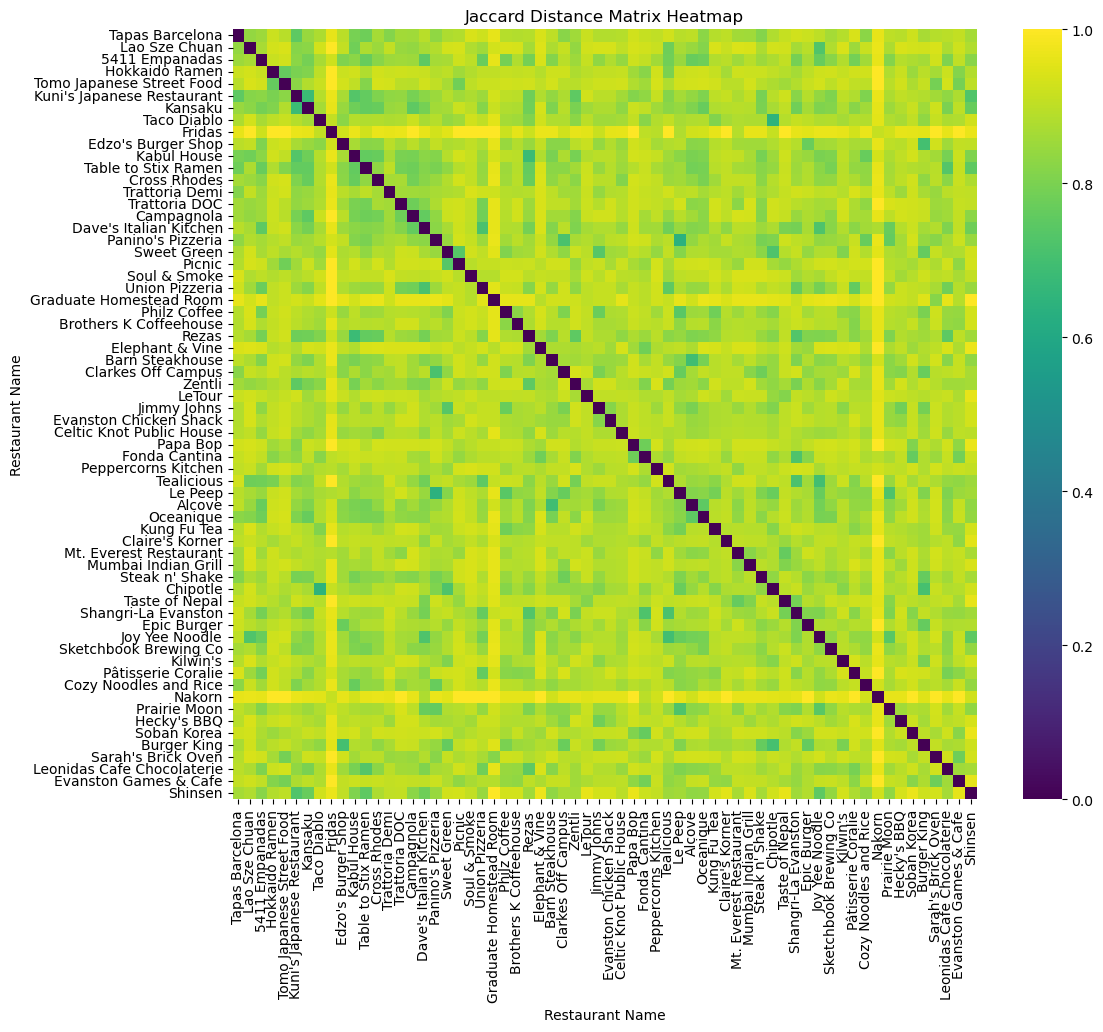

In [77]:
plt.figure(figsize=(12, 10))  # Increase the figure size for better visibility
sns.heatmap(Jaccard_matrix, cmap='viridis', xticklabels=True, yticklabels=True)
plt.title('Jaccard Distance Matrix Heatmap')
plt.savefig('Image_Lab_2/heat_jaccard.jpg', bbox_inches='tight')
plt.show()

In [78]:
Jaccard_matrix.loc['Burger King', 'Edzo\'s Burger Shop']

0.7

In [79]:
Jaccard_matrix.loc['Burger King', 'Oceanique']

0.88

In [80]:
Jaccard_matrix.loc['Lao Sze Chuan', 'Kabul House']

0.78125

## 13) Note that Jaccard distance can make reccommendations by taking a restaurant the user likes and finding the restaurant that is closest to this liked restaurant, in terms of the jaccard distance. Using this method, please make reccommendations for the users 'Calvin Smith' and 'Solomon M'

In [81]:
content_based_recommendation('Calvin Smith', distance_df = Jaccard_matrix)

Restaurant Name
Fonda Cantina                 0.777778
Soban Korea                   0.809524
Kuni's Japanese Restaurant    0.814815
Evanston Games & Cafe         0.833333
Hokkaido Ramen                0.857143
Elephant & Vine               0.857143
Tealicious                    0.869565
Picnic                        0.869565
Sarah's Brick Oven            0.875000
Shangri-La Evanston           0.875000
Name: Papa Bop, dtype: float64

In [82]:
content_based_recommendation('Solomon M', distance_df = Jaccard_matrix)

Restaurant Name
Hokkaido Ramen                0.761905
Picnic                        0.782609
Evanston Games & Cafe         0.789474
Sarah's Brick Oven            0.791667
Table to Stix Ramen           0.814815
Kuni's Japanese Restaurant    0.827586
Fonda Cantina                 0.857143
Taste of Nepal                0.857143
Sweet Green                   0.869565
Chipotle                      0.875000
Name: Tomo Japanese Street Food, dtype: float64